<a href="https://colab.research.google.com/github/jhashekhar/dnn-exp/blob/master/mnist_logs/bsize_4_inpsize_10_adam_epoch_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x58cd2000 @  0x7f81060f22a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision import transforms

In [3]:
trainset = torchvision.datasets.MNIST(root='data/', 
                                      train=True, 
                                      transform = torchvision.transforms.Compose([
                                          transforms.Resize(10),
                                          transforms.ToTensor()]),
                                      download=True)

testset = torchvision.datasets.MNIST(root='data/', 
                                     train=False,
                                     transform = torchvision.transforms.Compose([
                                         transforms.Resize(10), 
                                         transforms.ToTensor()]), 
                                     download=True)

Processing...
Done!


In [0]:
split = 0.1
dataset_size = len(trainset)
indices = list(range(dataset_size))
np.random.shuffle(indices)
val_split = int(np.floor(split * dataset_size))
train_indices = indices[val_split:]
val_indices = indices[:val_split] 

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

torch.Size([1, 10, 10])
torch.Size([10, 10])
Label: 4


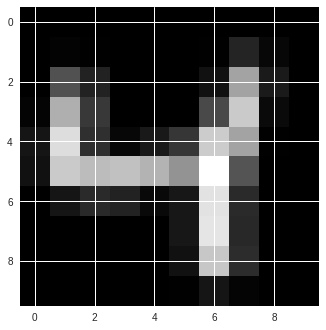

In [5]:
import matplotlib.pyplot as plt
img = trainset[2][0]
print(img.shape)
img = img.reshape(10, 10)
print(img.shape)
print('Label: {}'.format(trainset[2][1].item()))
plt.gray()
plt.imshow(img)

In [0]:
dataloaders = {'train': torch.utils.data.DataLoader(trainset, batch_size=4, sampler=train_sampler),
               'val': torch.utils.data.DataLoader(trainset, batch_size=4, sampler=valid_sampler),
               'test': torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)
              }

In [0]:
data_lengths = {'train': len(train_indices), 'val': len(val_indices), 'test': len(testset)}

In [10]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(100, 25)
        self.fc2 = nn.Linear(25, 10)
        
    def forward(self, x):
        z1 = F.relu(self.fc1(x.view(4, -1)))
        out = self.fc2(z1)
        return out, z1
    
net = Net()
net = net.to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [16]:
num_epochs = 100
fc2_norm = []
fc1_norm = []
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(num_epochs):
    print('Epoch: {}/{}'.format(epoch+1, num_epochs))
    print('='*10)
    
    for phase in ['train', 'val']:
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(dataloaders[phase]):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            _, preds = torch.max(outputs[0], 1)
            loss = criterion(outputs[0], labels)
            if phase == 'train':
                loss.backward()
                optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss/data_lengths[phase]
        epoch_acc = running_corrects/data_lengths[phase]
        
        if phase == 'train':
            fc1_norm.append(net.fc1.weight.grad.norm().item())
            fc2_norm.append(net.fc2.weight.grad.norm().item())
            train_loss.append(epoch_loss)
            train_acc.append(epoch_acc)
        else:
            val_loss.append(epoch_loss)
            val_acc.append(epoch_acc)            
        print('{} Loss: {:.4f},  Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print()
print('Finished Training')

Epoch: 1/100
train Loss: 0.1159,  Acc: 0.9649
val Loss: 0.1237,  Acc: 0.9635

Epoch: 2/100
train Loss: 0.1150,  Acc: 0.9652
val Loss: 0.1200,  Acc: 0.9625

Epoch: 3/100
train Loss: 0.1147,  Acc: 0.9657
val Loss: 0.1211,  Acc: 0.9630

Epoch: 4/100
train Loss: 0.1141,  Acc: 0.9654
val Loss: 0.1218,  Acc: 0.9638

Epoch: 5/100
train Loss: 0.1130,  Acc: 0.9660
val Loss: 0.1182,  Acc: 0.9638

Epoch: 6/100
train Loss: 0.1126,  Acc: 0.9658
val Loss: 0.1200,  Acc: 0.9610

Epoch: 7/100
train Loss: 0.1123,  Acc: 0.9662
val Loss: 0.1219,  Acc: 0.9640

Epoch: 8/100
train Loss: 0.1116,  Acc: 0.9668
val Loss: 0.1213,  Acc: 0.9642

Epoch: 9/100
train Loss: 0.1111,  Acc: 0.9661
val Loss: 0.1188,  Acc: 0.9627

Epoch: 10/100
train Loss: 0.1106,  Acc: 0.9664
val Loss: 0.1175,  Acc: 0.9655

Epoch: 11/100
train Loss: 0.1097,  Acc: 0.9671
val Loss: 0.1150,  Acc: 0.9648

Epoch: 12/100
train Loss: 0.1098,  Acc: 0.9665
val Loss: 0.1140,  Acc: 0.9648

Epoch: 13/100
train Loss: 0.1087,  Acc: 0.9670
val Loss: 0.11

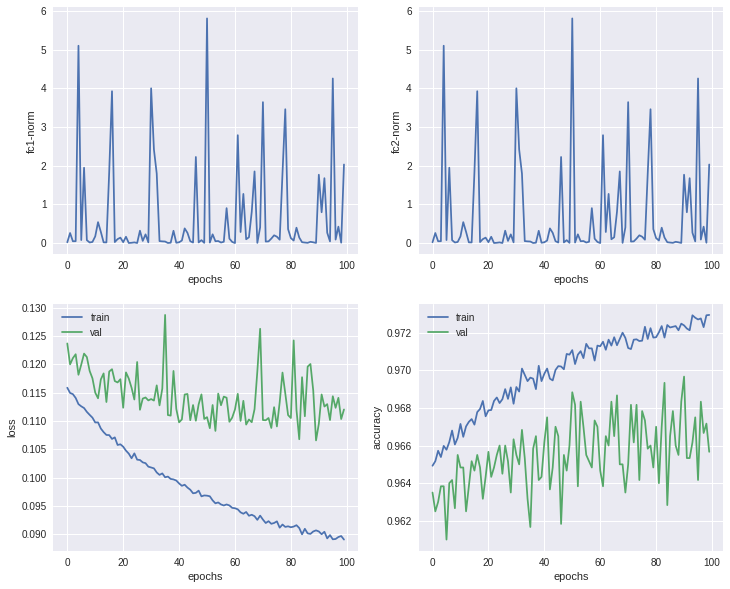

In [17]:
epoch_idx = [i for i in range(num_epochs)]
plt.figure(figsize=(12, 10))

plt.subplot(221)
plt.plot(epoch_idx, fc1_norm)
plt.xlabel('epochs')
plt.ylabel('fc1-norm')

plt.subplot(222)
plt.plot(epoch_idx, fc1_norm)
plt.xlabel('epochs')
plt.ylabel('fc2-norm')


plt.subplot(223)
plt.plot(epoch_idx, train_loss)
plt.plot(epoch_idx, val_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(224)
plt.plot(epoch_idx, train_acc)
plt.plot(epoch_idx, val_acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [0]:
txt_list = ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'fc1_norm', 'fc2_norm']
txt_dict = {'train_loss': train_loss, 
            'train_acc': train_acc, 
            'val_loss': val_loss, 
            'val_acc': val_acc,
            'fc1_norm': fc1_norm,
            'fc2_norm': fc2_norm}

with open('log_adam_epoch_100_bsize_4.txt', 'w') as f:
    for item in txt_list:
        f.write(item)
        f.write("\n")
        for i in txt_dict[item]:
            f.write("%s, " % i)
        f.write("\n")